# Notebook P2 CHARPENTIER Nicolas


## Dans ce notebook, nous allons continuer d'analyser les données liées au Titanic, tout en incluant les nouvelles connaissances vu lors du derniers cours.

### Dans un premier temps, nous allons récupérer les données et les nettoyer, afin de débuter sur une base propre.

# 1. Nettoyage des données

In [4]:
import numpy as np
import scipy.stats as ss
import sklearn
import pandas as pd
%matplotlib inline
import csv as csv
import StringIO
import pydotplus
from sklearn.externals.six import StringIO 
from sklearn import datasets,tree

data = pd.read_csv('train.csv', header=0)

print(data.describe())
data.dtypes

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000         NaN    0.000000   
50%     446.000000    0.000000    3.000000         NaN    0.000000   
75%     668.500000    1.000000    3.000000         NaN    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  


C:\Program Files\Anaconda2\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Après un court rappel des données et de leur type, nous voyons qu'il existe des valeurs NaN pour la colonne [Age], remplaçons les par l'age median des passagers en fonction de leur Sexe/Age/Classe. Nous voyons aussi que nous pouvons passer le genre des passagers sous forme d'entiers (0 ou 1), ce qui sera plus simple pour le futur de nos analyses.
Procédons désormais à ces modifications.

In [5]:
#Formatage de la colonne Sex pour passer le genre sous forme d'entiers
data['Sexe'] = 4
data['Sexe'] = data['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

#Definition des ages médians
median_ages = np.zeros((2,3))
for i in range(0, 2):
    for j in range(0, 3):
        median_ages[i,j] = data[(data['Sexe'] == i) & \
                              (data['Pclass'] == j+1)]['Age'].dropna().median()
        
print("Aperçu des ages médians :")
print(median_ages)

#Mapping des données de Age dans la nouvelle colonne newAge
data['newAge'] = data['Age']

#Remplissage de newAge et affichage d'un extrait de résultat
for i in range(0, 2):
    for j in range(0, 3):
        data.loc[ (data.Age.isnull()) & (data.Sexe == i) & 
                (data.Pclass == j+1),\
                'newAge'] = median_ages[i,j]
data[ data['Age'].isnull() ][['Sexe','Pclass','Age','newAge']].head(10)

Aperçu des ages médians :
[[ 35.   28.   21.5]
 [ 40.   30.   25. ]]


,Sexe,Pclass,Age,newAge
5,1,3,NaN,25.0
17,1,2,NaN,30.0
19,0,3,NaN,21.5
26,1,3,NaN,25.0
28,0,3,NaN,21.5
29,1,3,NaN,25.0
31,0,1,NaN,35.0
32,0,3,NaN,21.5
36,1,3,NaN,25.0
42,1,3,NaN,25.0


Maintenant que le nettoyage est terminé, nous allons pouvoir passer aux analyses.

# 2. Analyses de données

## 2.1. Analyse numéro 1

### 2.1.1. Description

Dans cette première analyse, nous allons étudier le nombre de personne ayant survécus/décédés en fonction de leur sexe, age, classe. Ceci afin d'essayer de tirer une première tendance, pour ensuite l'analyser plus précisément.

### 2.1.2. Réalisation

Dans un premier temps, comparons le nombre de personnes décédés/vivantes en fonction de leur classe et de leur sexe.

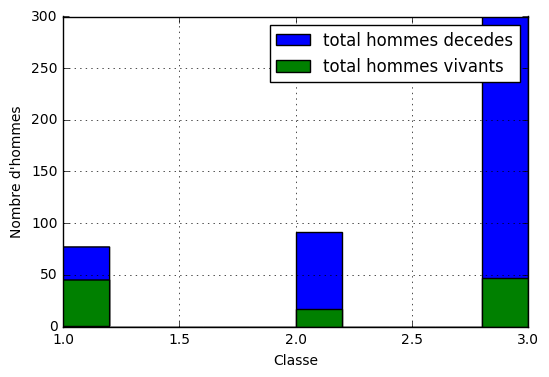

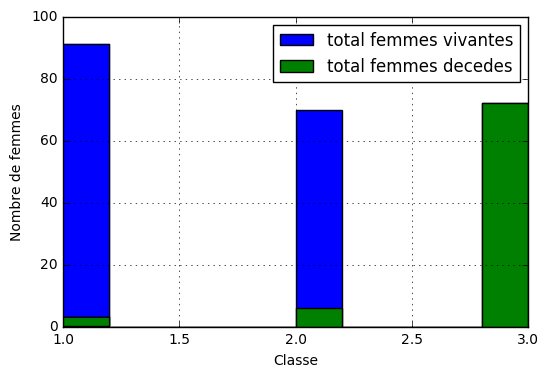

In [6]:
from matplotlib import pyplot

#graphique montrant le nombre d'hommes ayant survevu ou pas par classe
pyplot.hist(data[(data['Survived']==0)  & (data['Sexe']==1)]['Pclass'], label='total hommes decedes', color='blue')
pyplot.hist(data[(data['Survived']==1) & (data['Sexe']==1)]['Pclass'], label='total hommes vivants', color='green')
pyplot.xlabel('Classe')
pyplot.ylabel('Nombre d\'hommes')
pyplot.legend(loc='upper right')
pyplot.grid(True)
pyplot.show()

#graphique montrant le nombre de femmes ayant survevu ou pas par classe
pyplot.hist(data[(data['Survived']==1) & (data['Sexe']==0)]['Pclass'], label='total femmes vivantes', color='blue')
pyplot.hist(data[(data['Survived']==0)  & (data['Sexe']==0)]['Pclass'], label='total femmes decedes', color='green')
pyplot.xlabel('Classe')
pyplot.ylabel('Nombre de femmes')
pyplot.legend(loc='upper right')
pyplot.grid(True)
pyplot.show()




Nous voyons sur le premier graphique qu'il y a beaucoup plus d'hommes décédés que d'hommes survivants, et ceci est encore plus flagrant lorsque l'on regarde ces résultats sur les classes 2 et 3.

Pour ce qui est du deuxième graphique, nous voyons que c'est complètement l'inverse, il y a eu beaucoup plus de femmes sauvées que décédés, sauf pour la catégorie 3 qui parrait assez étrange.
En effet, le présent graphique superpose les colonnes, ce qui peut être très utile, sauf dans le cas ou les 2 valeurs sont identiques, et c'est le cas présent ici, il y a exactement 72 femmes qui ont survécus, et 72 qui sont décédés en troisième classe :

In [7]:
#Explication de la 3e colonne
cas1 = data[(data['Survived']==1) & (data['Sexe']==0) & (data['Pclass']==3)]
cas1 = cas1['Survived'].count()
print('Nombre de femmes ayant survecus en classe 3 : ' + str(cas1) )

cas2 = data[(data['Survived']==1) & (data['Sexe']==0) & (data['Pclass']==3)]
cas2 = cas2['Survived'].count()
print('Nombre de femmes ayant decedes en classe 3 : ' + str(cas2) )

Nombre de femmes ayant survecus en classe 3 : 72
Nombre de femmes ayant decedes en classe 3 : 72


Il faut donc faire attention à ce genre d'interprétation.

Dans un second temps, comparons le nombre de survivants/décédés en fonction de leur sexe, leur classe, et de leur age 

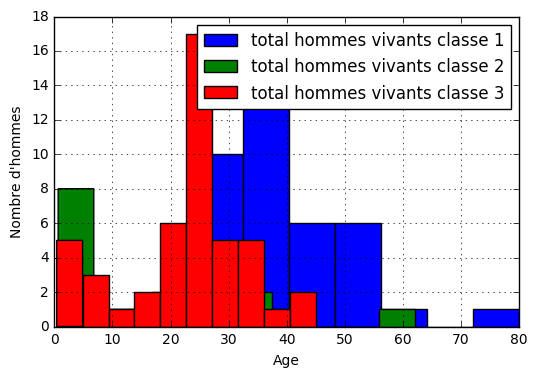

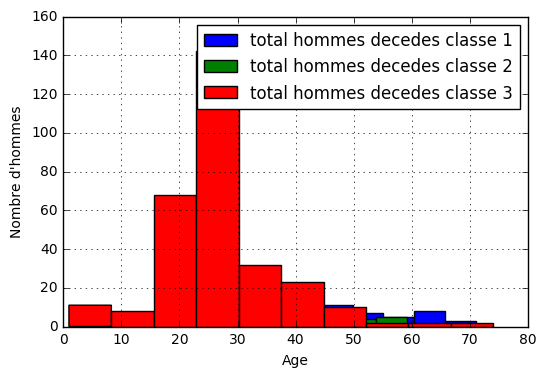

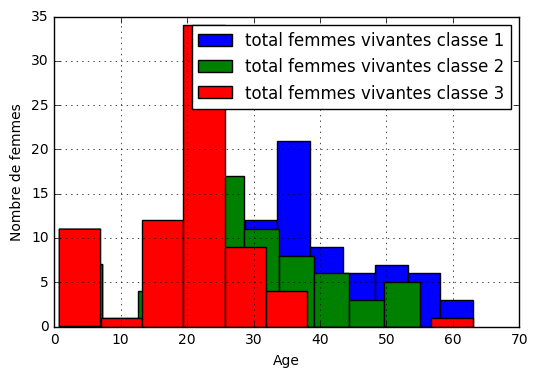

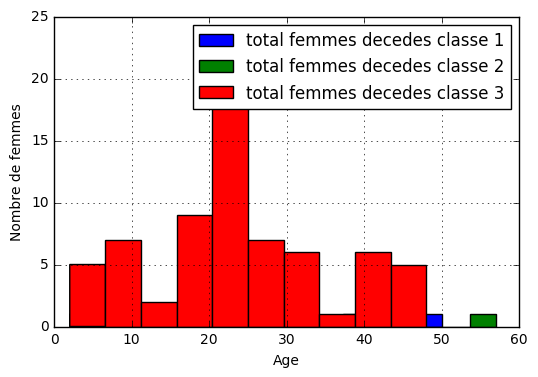

In [8]:
#graphique montrant le nombre d'hommes survivant en fonction de leur classe
pyplot.hist(data[(data['Survived']==1) & (data['Sexe']==1) & (data['Pclass']==1)]['newAge'], label='total hommes vivants classe 1')
pyplot.hist(data[(data['Survived']==1) & (data['Sexe']==1) & (data['Pclass']==2)]['newAge'], label='total hommes vivants classe 2')
pyplot.hist(data[(data['Survived']==1) & (data['Sexe']==1) & (data['Pclass']==3)]['newAge'], label='total hommes vivants classe 3')
pyplot.xlabel('Age')
pyplot.ylabel('Nombre d\'hommes')
pyplot.legend(loc='upper right')
pyplot.grid(True)
pyplot.show()

#graphique montrant le nombre d'hommes decedes en fonction de leur classe
pyplot.hist(data[(data['Survived']==0) & (data['Sexe']==1) & (data['Pclass']==1)]['newAge'], label='total hommes decedes classe 1')
pyplot.hist(data[(data['Survived']==0) & (data['Sexe']==1) & (data['Pclass']==2)]['newAge'], label='total hommes decedes classe 2')
pyplot.hist(data[(data['Survived']==0) & (data['Sexe']==1) & (data['Pclass']==3)]['newAge'], label='total hommes decedes classe 3')
pyplot.xlabel('Age')
pyplot.ylabel('Nombre d\'hommes')
pyplot.legend(loc='upper right')
pyplot.grid(True)
pyplot.show()

#graphique montrant le nombre de femmes vivantes en fonction de leur classe
pyplot.hist(data[(data['Survived']==1) & (data['Sexe']==0) & (data['Pclass']==1)]['newAge'], label='total femmes vivantes classe 1')
pyplot.hist(data[(data['Survived']==1) & (data['Sexe']==0) & (data['Pclass']==2)]['newAge'], label='total femmes vivantes classe 2')
pyplot.hist(data[(data['Survived']==1) & (data['Sexe']==0) & (data['Pclass']==3)]['newAge'], label='total femmes vivantes classe 3')
pyplot.xlabel('Age')
pyplot.ylabel('Nombre de femmes')
pyplot.legend(loc='upper right')
pyplot.grid(True)
pyplot.show()

#graphique montrant le nombre de femmes decedes en fonction de leur classe
pyplot.hist(data[(data['Survived']==0) & (data['Sexe']==0) & (data['Pclass']==1)]['newAge'], label='total femmes decedes classe 1')
pyplot.hist(data[(data['Survived']==0) & (data['Sexe']==0) & (data['Pclass']==2)]['newAge'], label='total femmes decedes classe 2')
pyplot.hist(data[(data['Survived']==0) & (data['Sexe']==0) & (data['Pclass']==3)]['newAge'], label='total femmes decedes classe 3')
pyplot.xlabel('Age')
pyplot.ylabel('Nombre de femmes')
pyplot.legend(loc='upper right')
pyplot.grid(True)
pyplot.show()

### 2.1.3. Conclusion

Nous voyons par ces graphiques que nous pouvons tirer 2 grandes tendances :
    - La classe numéro 1 est celle qui a connu le moins de personnes décédés, aussi bien pour les hommes que pour les femmes,
    - Les hommes sont décédés en grandes majorités

## 2.2. Analyse numéro 2

### 2.2.1. Description 

Nous allons dans cette partie essayer de justifier les 2 tendances émises ci-dessus, afin de pouvoir en tirer des conséquences plus concrètes.

### 2.2.2. Réalisation

Coefficients:[[-13.63530423]]
Residual sum of squares: 217.72
Variance score: 0.38


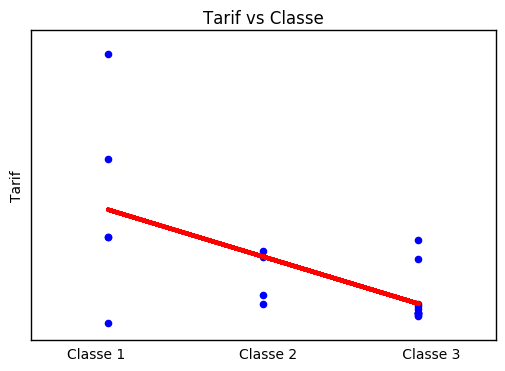

In [9]:
from sklearn import datasets, linear_model

data_X_test = data['Pclass'].to_frame()[-20:]
data_y_test = data['Fare'].to_frame()[-20:]
regr = linear_model.LinearRegression()

regr.fit(data_X_test, data_y_test)

print('Coefficients:' +  str(regr.coef_))

print("Residual sum of squares: %.2f"
      % np.mean((regr.predict(data_X_test) - data_y_test) ** 2))

print('Variance score: %.2f' % regr.score(data_X_test, data_y_test))

pyplot.title('Tarif vs Classe')
pyplot.xlabel('Classe 1                          Classe 2                        Classe 3')
pyplot.ylabel('Tarif')
pyplot.scatter(data_X_test, data_y_test,  color='blue')
pyplot.plot(data_X_test, regr.predict(data_X_test), color='red',
         linewidth=3)
pyplot.xticks(())
pyplot.yticks(())

pyplot.show()

Grace à la regression linéaire entre le tarif et la classe, nous pouvons voir que le prix est de plus en plus bas lorsque l'on approche de la catégorie 3, et à l'inverse de plus en plus haut lorsque l'on touche la classe 1.

Coefficients:[[-0.62637363]]
Residual sum of squares: 0.16
Variance score: 0.36


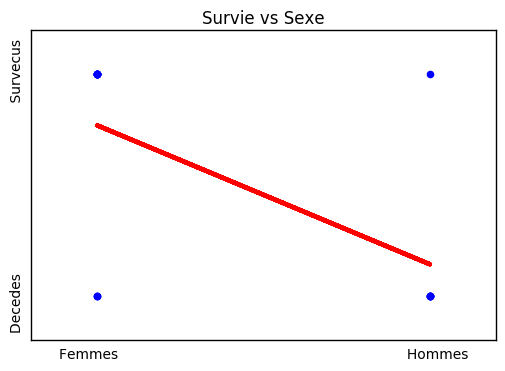

In [10]:
from sklearn import datasets, linear_model

data_X_test = data['Survived'].to_frame()[-20:]
data_y_test = data['Sexe'].to_frame()[-20:]
regr = linear_model.LinearRegression()
regr.fit(data_X_test, data_y_test)

print('Coefficients:' +  str(regr.coef_))
print("Residual sum of squares: %.2f"
      % np.mean((regr.predict(data_X_test) - data_y_test) ** 2))
print('Variance score: %.2f' % regr.score(data_X_test, data_y_test))

pyplot.title('Survie vs Sexe')
pyplot.xlabel('Femmes                                                                  Hommes')
pyplot.ylabel('Decedes                                       Survecus')
pyplot.scatter(data_X_test, data_y_test,  color='blue')
pyplot.plot(data_X_test, regr.predict(data_X_test), color='red',
         linewidth=3)
pyplot.xticks(())
pyplot.yticks(())

pyplot.show()

Cette regression lineaire, aussi simple soit-elle, confirme la deuxième grande tendance, qui est que beaucoup plus d'hommes sont décédés que de femmes, ce qui confirme qu'une des célèbres phrases du film culte a été appliquée (du moins à moitié pour sur) avec succès : "Les femmes et les enfants d'abords" ! :)


Allons désormais un petit peu plus loin et analysons ces 2 grandes tendances ensemble :

In [13]:
clf = tree.DecisionTreeClassifier(criterion='entropy')

data_X_train = data[['Survived','Sexe']][:-20]
data_y_train = data['Pclass'][:-20]

clf = clf.fit(data_X_train, data_y_train)
from IPython.display import Image  
dot_data = StringIO()
tree.export_graphviz(clf, out_file=dot_data,   
                         filled=True, rounded=True)
graph = pydotplus.pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png()) 

InvocationException: GraphViz's executables not found

Pour confirmer les tendances émisent plus tôt dans ce rapport, voici un arbre décisionnel nous montrant le nombre de personne ayant décédés (pour le cas 'True') : 79 pour la classe 1, 95 pour la classe 2, et 362 pour la classe 3. 
On voit donc que la classe 3 a été beaucoup plus négligé que les 2 autres, et si on regarde la 2eme branche, on s'aperçois que lorsqu'on ajoute une condition sur le sexe, la majorité des personnes décédés sont des hommes, en classe 3. 
Nous voyons par ailleurs que seulement 79 personnes de classe 1 ont péris dans le naufrage du titanic, dont uniquement 3 femmes, ce qui confirme toutes les hypothèses précédentes.

### 2.2.3. Conclusion

Nous avons dans cette partie démontré la corrélation entre les chances de survies, en fonction des classes (et donc des prix) ainsi que du sexe. Essayons maintenant de prédire si oui ou non un passager pris au hasard aurait survécu au naufrage ou pas.

# 3. Conclusion générale

Pour conclure ce rapport d'analyses, nous pouvons expréssément affirmer que deux facteurs ont assuré un rôle majeur dans la survie d'un passager : Son sexe et sa classe, et en conséquence donc le prix investi dans le voyage.

En effet, ces analyses nous montrent que le prix investi dans le voyage a joué un rôle majeur, ce qui parrait très inégale, et mériterait plus d'investigation. Cependant, Nous voyons qu'au delà du prix et de la classe, le sexe permet de filtrer encore un peu plus sur la survi d'un passager.

La prochaine phase a réaliser selon moi serait de réussir à déterminer, prédire la survie ou non d'un passager généré aléatoirement en fonction de sa classe, son sexe, puis son age, et ensuite inclure le maximum de données utiles à cette analyse.
